1. On récupère les données de l'API

In [138]:
import requests, json, pandas as pd
from pandas.io.json import json_normalize

# On commence par récupérer les datas de l'API

parametres = {
    'start_date':'2019-01-01',
    'end_date':'2019-09-07',
    'columns':['spend','revenue','profit','margin','nb_impressions','ecpm']}

r = requests.post('https://data-analyst-test.madboxgames.io/api/public/profit/get',params=parametres)


2. On transforme les données en dataframe

In [142]:
data = r.text

j = json.loads(data)

y = j['data']

df = pd.DataFrame(j['data']['data'])


df['date'] = pd.to_datetime(df['date']) 
df.set_index('date', inplace=True)

df.head()

,ecpm,margin,nb_impressions,profit,revenue,spend
date,,,,,,
2019-01-01,49.59,0.34,59751.76,993.28,2963.14,1969.86
2019-01-02,49.98,0.32,62299.62,1002.36,3113.48,2111.12
2019-01-03,48.27,0.34,65199.64,1074.17,3146.88,2072.72
2019-01-04,49.73,0.33,63996.98,1061.52,3182.79,2121.26
2019-01-05,48.49,0.32,64038.54,992.10,3105.02,2112.92


3. On analyse les différentes données

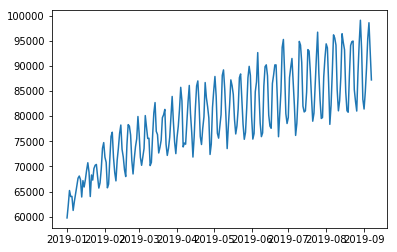

In [147]:
import matplotlib.pyplot as plt

#plt.plot(df.index, df.ecpm)
#plt.plot(df.index, df.margin)
plt.plot(df.index, df.nb_impressions)
#plt.plot(df.index, df.profit)
#plt.plot(df.index, df.revenue)
#plt.plot(df.index, df.spend)


plt.show()

In [145]:
import numpy as np

r=np.corrcoef(df.spend, df.nb_impressions)

r

#df.apply(lambda x: x.loc[:, "margin"] * x.loc[:, "revenue"])

array([[ 1.        ,  0.97703771],
       [ 0.97703771,  1.        ]])